## Preliminary tests
TO test : OSVM, Isolation Forest, Decision tree, LocalOutlierFactor, NN

In [4]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy import stats
import seaborn as sns
import pickle as pkl

In [5]:
# Load data
from scipy.io import loadmat
x = loadmat('data/satimage-2.mat')
X = x["X"]
y = x["y"]
y = [val[0] for val in y]

print("Number of observations : ",X.shape[0])
print("Number of variables : ",X.shape[1])

Number of observations :  5803
Number of variables :  36


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
def plot_confusion(y_pred, y=y):
    labels = ['Inliers','Outlier']
    sns.heatmap(confusion_matrix(y_true = y,y_pred = y_pred), xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds") 
    plt.title('Matrice de confusion')
    plt.show()


# pyod library
https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

TODO
- nb of FP and FN as a function of contamination score for each method
- compare with contamination score
--> what happens if the contamination rate is not good at all ? under/overestimate ==> impact 
--> try with a wrong estimation (eg no shuffle?)
--> theoretically 
- fine tuning :
    - number of neighbors
    - HBOS & AE ?
- compare anomaly detection from outlier detection ? (use test & train?)
- comparison of algos : how much is it sensitive to parameter tuning ? + add time estimate ? 

In [8]:
# # ! pip install pyod
# knn
from pyod.models.knn import KNN
# angle based
from pyod.models.abod import ABOD
# histogram
from pyod.models.hbos import HBOS
# autoencoders
from pyod.models.auto_encoder import AutoEncoder

Using TensorFlow backend.


In [9]:
# estimate outlier fraction only based on trainset
outlier_fraction = sum(y_train)/len(y_train)

# # estimate outlier fraction only based on entire dataset
# outlier_fraction = sum(y)/len(y)

print("Fraction of outliers in the dataset : ", outlier_fraction)

Fraction of outliers in the dataset :  0.012088477366255145


In [10]:
args = {}
args["contamination"] = [outlier_fraction, 1e-10, 1e-3, 1e-2, outlier_fraction/2, outlier_fraction*2, 0.5, 0.99]
args["n_neighbors"] = 5

In [11]:
# Initialize classifier
classifiers = {
     'ABOD'   : ABOD(contamination=outlier_fraction, n_neighbors=args["n_neighbors"]),
     'KNN' :  KNN(contamination=outlier_fraction, n_neighbors=args["n_neighbors"]),
     'Average KNN': KNN(method='mean',contamination=outlier_fraction, n_neighbors=args["n_neighbors"]),
     'Median KNN': KNN(method='median',contamination=outlier_fraction, n_neighbors=args["n_neighbors"]),
     'HBOS' : HBOS(contamination=outlier_fraction),
     'AutoEncoder' : AutoEncoder(contamination=outlier_fraction)
}

In [12]:
print(classifiers["KNN"])
print(classifiers["HBOS"])
print(classifiers["AutoEncoder"])

KNN(algorithm='auto', contamination=0.012088477366255145, leaf_size=30,
  method='largest', metric='minkowski', metric_params=None, n_jobs=1,
  n_neighbors=5, p=2, radius=1.0)
HBOS(alpha=0.1, contamination=0.012088477366255145, n_bins=10, tol=0.5)
AutoEncoder(batch_size=32, contamination=0.012088477366255145,
      dropout_rate=0.2, epochs=100, hidden_activation='relu',
      hidden_neurons=[64, 32, 32, 64], l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000022CCDAB2678>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)


In [13]:
dict_clf={}
df_result = pd.DataFrame({"y_test" : np.array(y_test).astype(int)})
dict_result={}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    print("\n---------------------"+clf_name+"---------------------")
    print("Classifier with correct contamination : ", clf)
    dict_result[clf_name]={}
    dict_clf[clf_name]={}
    
    for contamination in args["contamination"]:
        print('\n----Contamination rate : '+str(contamination)+'----')
        
        # update contamination of the classifier
        clf.contamination=contamination
        
        # define contamination name (for backup purpose)
        if contamination == outlier_fraction:
            contamination_name = "outlier"
        else :
            contamination_name = str(contamination)
        dict_result[clf_name][contamination_name]={}
        
        # Fit on training data
        clf.fit(X_train)
        dict_clf[clf_name][contamination_name]=clf
        
        # Predict raw anomaly score on test data
        scores_pred = -clf.decision_function(X_test) # take the negative to get a positive number for an anomaly
        df_result[str("score_"+clf_name+contamination_name)] = scores_pred

        # Threshold value to consider a datapoint inlier or outlier
        threshold = stats.scoreatpercentile(scores_pred,100 * contamination)
        print("threshold value : ", threshold)
#         df_result[str("thres_"+clf_name+contamination_name)] = threshold
        dict_result[clf_name][contamination_name]["thres"] = threshold
        
        # Prediction 
        y_pred = clf.predict(X_test)
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        df_result[str("y_pred_"+clf_name+contamination_name)] = y_pred.tolist()
        print('Number of outliers : ',n_outliers,'\nNumber of inliers : ',n_inliers)

        # no of errors in prediction
        n_errors = np.sum(y_pred != np.array(y_test))
        print('Number of errors : ',n_errors)
        dict_result[clf_name][contamination_name]["n_errors"] = n_errors
        FP = np.sum((np.array(y_test)==0) & (y_pred==1))
        print("Number of FP : ",FP)
        dict_result[clf_name][contamination_name]["FP"] = FP
        FN = np.sum((np.array(y_test)==1) & (y_pred==0))
        print("Number of FN : ",FN)
        dict_result[clf_name][contamination_name]["FN"] = FN
        
#         # plot confusion matrix
#         plot_confusion(y_pred, y=y)


---------------------ABOD---------------------
Classifier with correct contamination :  ABOD(contamination=0.012088477366255145, method='fast', n_neighbors=5)

----Contamination rate : 0.012088477366255145----
threshold value :  4.609615751895344e-09
Number of outliers :  25 
Number of inliers :  1890
Number of errors :  35
Number of FP :  18
Number of FN :  17

----Contamination rate : 1e-10----
threshold value :  7.093764999491746e-10
Number of outliers :  0 
Number of inliers :  1915
Number of errors :  24
Number of FP :  0
Number of FN :  24

----Contamination rate : 0.001----
threshold value :  1.6135406340082427e-09
Number of outliers :  1 
Number of inliers :  1914
Number of errors :  25
Number of FP :  1
Number of FN :  24

----Contamination rate : 0.01----
threshold value :  3.966925081167471e-09
Number of outliers :  20 
Number of inliers :  1895
Number of errors :  30
Number of FP :  13
Number of FN :  17

----Contamination rate : 0.006044238683127572----
threshold value : 

Number of outliers :  48 
Number of inliers :  1867
Number of errors :  36
Number of FP :  30
Number of FN :  6

----Contamination rate : 0.5----
threshold value :  -110.34817464326946
Number of outliers :  969 
Number of inliers :  946
Number of errors :  945
Number of FP :  945
Number of FN :  0

----Contamination rate : 0.99----
threshold value :  -108.79668130726404
Number of outliers :  1902 
Number of inliers :  13
Number of errors :  1878
Number of FP :  1878
Number of FN :  0

---------------------AutoEncoder---------------------
Classifier with correct contamination :  AutoEncoder(batch_size=32, contamination=0.012088477366255145,
      dropout_rate=0.2, epochs=100, hidden_activation='relu',
      hidden_neurons=[64, 32, 32, 64], l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000022CCDAB2678>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

----Contamination rate : 0.012088477

3499/3499 [==============================] - 1s 305us/step - loss: 1.3232 - val_loss: 1.4307
Epoch 49/100
3499/3499 [==============================] - 1s 248us/step - loss: 1.3091 - val_loss: 1.4187
Epoch 50/100
3499/3499 [==============================] - 1s 279us/step - loss: 1.2985 - val_loss: 1.4075
Epoch 51/100
3499/3499 [==============================] - 1s 393us/step - loss: 1.2853 - val_loss: 1.3971
Epoch 52/100
3499/3499 [==============================] - 1s 284us/step - loss: 1.2721 - val_loss: 1.3868
Epoch 53/100
3499/3499 [==============================] - 1s 224us/step - loss: 1.2624 - val_loss: 1.3761
Epoch 54/100
3499/3499 [==============================] - 1s 246us/step - loss: 1.2531 - val_loss: 1.3669
Epoch 55/100
3499/3499 [==============================] - 1s 239us/step - loss: 1.2413 - val_loss: 1.3576
Epoch 56/100
3499/3499 [==============================] - 1s 217us/step - loss: 1.2333 - val_loss: 1.3480
Epoch 57/100
3499/3499 [==============================] - 1

3499/3499 [==============================] - 1s 200us/step - loss: 9.5886 - val_loss: 7.7030
Epoch 4/100
3499/3499 [==============================] - 1s 192us/step - loss: 7.1070 - val_loss: 6.0537
Epoch 5/100
3499/3499 [==============================] - 1s 192us/step - loss: 5.7255 - val_loss: 5.0450
Epoch 6/100
3499/3499 [==============================] - 1s 197us/step - loss: 4.8822 - val_loss: 4.3810
Epoch 7/100
3499/3499 [==============================] - 1s 191us/step - loss: 4.2926 - val_loss: 3.9082
Epoch 8/100
3499/3499 [==============================] - 1s 195us/step - loss: 3.8825 - val_loss: 3.5497
Epoch 9/100
3499/3499 [==============================] - 1s 194us/step - loss: 3.5515 - val_loss: 3.2720
Epoch 10/100
3499/3499 [==============================] - 1s 194us/step - loss: 3.2844 - val_loss: 3.0483
Epoch 11/100
3499/3499 [==============================] - 1s 193us/step - loss: 3.0782 - val_loss: 2.8657
Epoch 12/100
3499/3499 [==============================] - 1s 196u

3499/3499 [==============================] - 1s 200us/step - loss: 1.0908 - val_loss: 1.0476
Epoch 81/100
3499/3499 [==============================] - 1s 196us/step - loss: 1.0857 - val_loss: 1.0438
Epoch 82/100
3499/3499 [==============================] - 1s 197us/step - loss: 1.0821 - val_loss: 1.0402
Epoch 83/100
3499/3499 [==============================] - 1s 197us/step - loss: 1.0787 - val_loss: 1.0367
Epoch 84/100
3499/3499 [==============================] - 1s 196us/step - loss: 1.0752 - val_loss: 1.0332
Epoch 85/100
3499/3499 [==============================] - 1s 193us/step - loss: 1.0714 - val_loss: 1.0299
Epoch 86/100
3499/3499 [==============================] - 1s 188us/step - loss: 1.0682 - val_loss: 1.0268
Epoch 87/100
3499/3499 [==============================] - 1s 195us/step - loss: 1.0650 - val_loss: 1.0244
Epoch 88/100
3499/3499 [==============================] - 1s 194us/step - loss: 1.0618 - val_loss: 1.0211
Epoch 89/100
3499/3499 [==============================] - 1

3499/3499 [==============================] - 1s 200us/step - loss: 1.5717 - val_loss: 1.5145
Epoch 36/100
3499/3499 [==============================] - 1s 196us/step - loss: 1.5501 - val_loss: 1.4929
Epoch 37/100
3499/3499 [==============================] - 1s 198us/step - loss: 1.5283 - val_loss: 1.4729
Epoch 38/100
3499/3499 [==============================] - 1s 195us/step - loss: 1.5055 - val_loss: 1.4534
Epoch 39/100
3499/3499 [==============================] - 1s 196us/step - loss: 1.4896 - val_loss: 1.4352
Epoch 40/100
3499/3499 [==============================] - 1s 194us/step - loss: 1.4685 - val_loss: 1.4169
Epoch 41/100
3499/3499 [==============================] - 1s 207us/step - loss: 1.4525 - val_loss: 1.4004
Epoch 42/100
3499/3499 [==============================] - 1s 197us/step - loss: 1.4364 - val_loss: 1.3845
Epoch 43/100
3499/3499 [==============================] - 1s 200us/step - loss: 1.4173 - val_loss: 1.3686
Epoch 44/100
3499/3499 [==============================] - 1

Train on 3499 samples, validate on 389 samples
Epoch 1/100
3499/3499 [==============================] - 2s 653us/step - loss: 54.6553 - val_loss: 20.2179
Epoch 2/100
3499/3499 [==============================] - 1s 195us/step - loss: 14.1300 - val_loss: 11.0568
Epoch 3/100
3499/3499 [==============================] - 1s 195us/step - loss: 8.9461 - val_loss: 7.8962
Epoch 4/100
3499/3499 [==============================] - 1s 197us/step - loss: 6.7171 - val_loss: 6.2346
Epoch 5/100
3499/3499 [==============================] - 1s 200us/step - loss: 5.4638 - val_loss: 5.2279
Epoch 6/100
3499/3499 [==============================] - 1s 197us/step - loss: 4.6949 - val_loss: 4.5407
Epoch 7/100
3499/3499 [==============================] - 1s 200us/step - loss: 4.1503 - val_loss: 4.0460
Epoch 8/100
3499/3499 [==============================] - 1s 198us/step - loss: 3.7387 - val_loss: 3.6721
Epoch 9/100
3499/3499 [==============================] - 1s 197us/step - loss: 3.4196 - val_loss: 3.3793
Epoc

3499/3499 [==============================] - 1s 197us/step - loss: 1.0929 - val_loss: 1.1546
Epoch 78/100
3499/3499 [==============================] - 1s 198us/step - loss: 1.0885 - val_loss: 1.1506
Epoch 79/100
3499/3499 [==============================] - 1s 198us/step - loss: 1.0838 - val_loss: 1.1464
Epoch 80/100
3499/3499 [==============================] - 1s 199us/step - loss: 1.0795 - val_loss: 1.1424
Epoch 81/100
3499/3499 [==============================] - 1s 202us/step - loss: 1.0757 - val_loss: 1.1389
Epoch 82/100
3499/3499 [==============================] - 1s 199us/step - loss: 1.0720 - val_loss: 1.1351
Epoch 83/100
3499/3499 [==============================] - 1s 213us/step - loss: 1.0683 - val_loss: 1.1314
Epoch 84/100
3499/3499 [==============================] - 1s 216us/step - loss: 1.0646 - val_loss: 1.1282
Epoch 85/100
3499/3499 [==============================] - 1s 201us/step - loss: 1.0609 - val_loss: 1.1249
Epoch 86/100
3499/3499 [==============================] - 1

3499/3499 [==============================] - 1s 237us/step - loss: 1.6521 - val_loss: 1.5981
Epoch 33/100
3499/3499 [==============================] - 1s 216us/step - loss: 1.6251 - val_loss: 1.5724
Epoch 34/100
3499/3499 [==============================] - 1s 235us/step - loss: 1.5980 - val_loss: 1.5486
Epoch 35/100
3499/3499 [==============================] - 1s 223us/step - loss: 1.5758 - val_loss: 1.5249
Epoch 36/100
3499/3499 [==============================] - 1s 211us/step - loss: 1.5537 - val_loss: 1.5037
Epoch 37/100
3499/3499 [==============================] - 1s 201us/step - loss: 1.5309 - val_loss: 1.4822
Epoch 38/100
3499/3499 [==============================] - 1s 203us/step - loss: 1.5101 - val_loss: 1.4620
Epoch 39/100
3499/3499 [==============================] - 1s 198us/step - loss: 1.4899 - val_loss: 1.4430
Epoch 40/100
3499/3499 [==============================] - 1s 199us/step - loss: 1.4707 - val_loss: 1.4251
Epoch 41/100
3499/3499 [==============================] - 1

Train on 3499 samples, validate on 389 samples
Epoch 1/100
3499/3499 [==============================] - 3s 774us/step - loss: 58.6549 - val_loss: 19.8465
Epoch 2/100
3499/3499 [==============================] - 1s 272us/step - loss: 15.4000 - val_loss: 10.5527
Epoch 3/100
3499/3499 [==============================] - 1s 220us/step - loss: 9.5407 - val_loss: 7.6396
Epoch 4/100
3499/3499 [==============================] - 1s 251us/step - loss: 7.1700 - val_loss: 6.0976
Epoch 5/100
3499/3499 [==============================] - 1s 225us/step - loss: 5.8007 - val_loss: 5.1312
Epoch 6/100
3499/3499 [==============================] - 1s 221us/step - loss: 4.9567 - val_loss: 4.4783
Epoch 7/100
3499/3499 [==============================] - 1s 229us/step - loss: 4.3609 - val_loss: 4.0042
Epoch 8/100
3499/3499 [==============================] - 1s 231us/step - loss: 3.9151 - val_loss: 3.6421
Epoch 9/100
3499/3499 [==============================] - 1s 240us/step - loss: 3.5775 - val_loss: 3.3570
Epoc

Epoch 78/100
3499/3499 [==============================] - 1s 247us/step - loss: 1.0965 - val_loss: 1.0999
Epoch 79/100
3499/3499 [==============================] - 1s 214us/step - loss: 1.0918 - val_loss: 1.0956
Epoch 80/100
3499/3499 [==============================] - 1s 221us/step - loss: 1.0874 - val_loss: 1.0915
Epoch 81/100
3499/3499 [==============================] - 1s 201us/step - loss: 1.0839 - val_loss: 1.0876
Epoch 82/100
3499/3499 [==============================] - 1s 195us/step - loss: 1.0796 - val_loss: 1.0839
Epoch 83/100
3499/3499 [==============================] - 1s 197us/step - loss: 1.0758 - val_loss: 1.0805
Epoch 84/100
3499/3499 [==============================] - 1s 200us/step - loss: 1.0721 - val_loss: 1.0769
Epoch 85/100
3499/3499 [==============================] - 1s 199us/step - loss: 1.0688 - val_loss: 1.0734
Epoch 86/100
3499/3499 [==============================] - 1s 197us/step - loss: 1.0655 - val_loss: 1.0702
Epoch 87/100
3499/3499 [======================

3499/3499 [==============================] - 1s 207us/step - loss: 1.6182 - val_loss: 1.5765
Epoch 34/100
3499/3499 [==============================] - 1s 211us/step - loss: 1.5930 - val_loss: 1.5533
Epoch 35/100
3499/3499 [==============================] - 1s 209us/step - loss: 1.5673 - val_loss: 1.5309
Epoch 36/100
3499/3499 [==============================] - 1s 204us/step - loss: 1.5477 - val_loss: 1.5100
Epoch 37/100
3499/3499 [==============================] - 1s 203us/step - loss: 1.5269 - val_loss: 1.4900
Epoch 38/100
3499/3499 [==============================] - 1s 212us/step - loss: 1.5070 - val_loss: 1.4709
Epoch 39/100
3499/3499 [==============================] - 1s 219us/step - loss: 1.4871 - val_loss: 1.4524
Epoch 40/100
3499/3499 [==============================] - 1s 253us/step - loss: 1.4651 - val_loss: 1.4346
Epoch 41/100
3499/3499 [==============================] - 1s 279us/step - loss: 1.4482 - val_loss: 1.4184
Epoch 42/100
3499/3499 [==============================] - 1

Train on 3499 samples, validate on 389 samples
Epoch 1/100
3499/3499 [==============================] - 3s 737us/step - loss: 53.2549 - val_loss: 18.8760
Epoch 2/100
3499/3499 [==============================] - 1s 189us/step - loss: 14.5548 - val_loss: 10.3835
Epoch 3/100
3499/3499 [==============================] - 1s 197us/step - loss: 9.0502 - val_loss: 7.4004
Epoch 4/100
3499/3499 [==============================] - 1s 191us/step - loss: 6.7452 - val_loss: 5.8424
Epoch 5/100
3499/3499 [==============================] - 1s 194us/step - loss: 5.4760 - val_loss: 4.8987
Epoch 6/100
3499/3499 [==============================] - 1s 190us/step - loss: 4.7087 - val_loss: 4.2753
Epoch 7/100
3499/3499 [==============================] - 1s 206us/step - loss: 4.1878 - val_loss: 3.8266
Epoch 8/100
3499/3499 [==============================] - 1s 259us/step - loss: 3.7818 - val_loss: 3.4887
Epoch 9/100
3499/3499 [==============================] - 1s 230us/step - loss: 3.4787 - val_loss: 3.2233
Epoc

3499/3499 [==============================] - 1s 193us/step - loss: 1.1043 - val_loss: 1.0292
Epoch 78/100
3499/3499 [==============================] - 1s 191us/step - loss: 1.1004 - val_loss: 1.0251
Epoch 79/100
3499/3499 [==============================] - 1s 198us/step - loss: 1.0963 - val_loss: 1.0209
Epoch 80/100
3499/3499 [==============================] - 1s 194us/step - loss: 1.0922 - val_loss: 1.0169
Epoch 81/100
3499/3499 [==============================] - 1s 192us/step - loss: 1.0877 - val_loss: 1.0131
Epoch 82/100
3499/3499 [==============================] - 1s 196us/step - loss: 1.0835 - val_loss: 1.0095
Epoch 83/100
3499/3499 [==============================] - 1s 196us/step - loss: 1.0802 - val_loss: 1.0061
Epoch 84/100
3499/3499 [==============================] - 1s 194us/step - loss: 1.0767 - val_loss: 1.0028
Epoch 85/100
3499/3499 [==============================] - 1s 196us/step - loss: 1.0734 - val_loss: 0.9995
Epoch 86/100
3499/3499 [==============================] - 1

In [55]:
def plot_result(dict_result, metric, remove_contam_beg = 0, remove_contam_end = 0) :
    for clf_name in dict_result.keys() :
        metric_list = []
        if remove_contam_end == 0 :
            contam_list = list(dict_result[clf_name].keys())[remove_contam_beg:]
            contam_nb = args["contamination"][remove_contam_beg:]
        else :
            contam_list = list(dict_result[clf_name].keys())[remove_contam_beg:-remove_contam_end]
            contam_nb = args["contamination"][remove_contam_beg:-remove_contam_end]
        for contamination in contam_list:
            try :
                metric_list.append(dict_result[clf_name][contamination][metric])
            except :
                break
        plt.scatter(np.log(contam_nb),metric_list,label = clf_name)
    plt.title(metric)
    plt.axvline(np.log(outlier_fraction), label='true outlier fraction')
    plt.legend()
    plt.show()

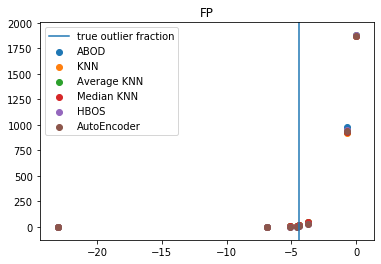

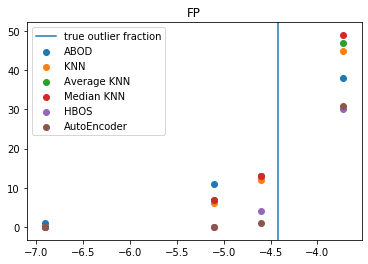

In [59]:
plot_result(dict_result, "FP")
plot_result(dict_result, "FP", remove_contam_beg = 2, remove_contam_end =2)

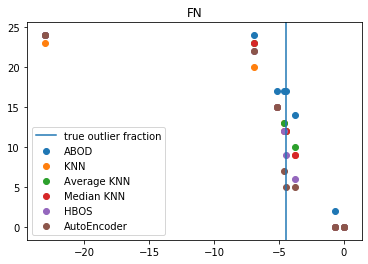

In [60]:
plot_result(dict_result, "FN")

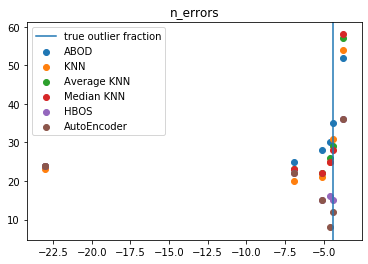

In [62]:
plot_result(dict_result, "n_errors",remove_contam_end = 2)

In [16]:
pkl.dump(df_result,open('pickles/df_result.pkl', 'wb') )
pkl.dump(dict_result,open('pickles/dict_result.pkl', 'wb') )
df_result.head()

,y_test,score_ABODoutlier,y_pred_ABODoutlier,score_ABOD1e-10,y_pred_ABOD1e-10,score_ABOD0.001,y_pred_ABOD0.001,score_ABOD0.01,y_pred_ABOD0.01,score_ABOD0.006044238683127572,...,score_AutoEncoder0.01,y_pred_AutoEncoder0.01,score_AutoEncoder0.006044238683127572,y_pred_AutoEncoder0.006044238683127572,score_AutoEncoder0.02417695473251029,y_pred_AutoEncoder0.02417695473251029,score_AutoEncoder0.5,y_pred_AutoEncoder0.5,score_AutoEncoder0.99,y_pred_AutoEncoder0.99
0,0,3.535245e-08,0,3.535245e-08,0,3.535245e-08,0,3.535245e-08,0,3.535245e-08,...,-3.395108,0,-3.394844,0,-3.395612,0,-3.395066,0,-3.395167,1
1,0,3.251472e-07,0,3.251472e-07,0,3.251472e-07,0,3.251472e-07,0,3.251472e-07,...,-7.197067,0,-7.194390,0,-7.197777,0,-7.196357,1,-7.197122,1
2,0,3.141807e-08,0,3.141807e-08,0,3.141807e-08,0,3.141807e-08,0,3.141807e-08,...,-6.441740,0,-6.443570,0,-6.441088,0,-6.442178,1,-6.441589,1
3,0,9.789379e-08,0,9.789379e-08,0,9.789379e-08,0,9.789379e-08,0,9.789379e-08,...,-3.637701,0,-3.635261,0,-3.637759,0,-3.636869,0,-3.637535,1
4,0,2.283796e-07,0,2.283796e-07,0,2.283796e-07,0,2.283796e-07,0,2.283796e-07,...,-8.081018,0,-8.078163,0,-8.081449,0,-8.080104,1,-8.081055,1
